# Cuaderno 27: El problema del agente viajero múltiple ($k$-ATSP)
## Formulación compacta

$\newcommand{\card}[1]{\left| #1 \right|}$
$\newcommand{\tabulatedset}[1]{\left\{ #1 \right\}}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$

Dados: 
* un grafo dirigido **completo** $D=(V,A)$, donde $V= \{0, \ldots, n\}$;
* un número entero $k$; y,
* un vector $c \in \ZZ^{A}$ de costos asociados a los arcos de $D$.

El *problema del agente viajero asimétrico múltiple (Multiple Asymmetric Traveling Salesman Problem, $k$-ATSP)* consiste en encontrar un conjunto de $k$ circuitos dirigidos con las siguientes propiedades:
* todos los circuitos deben contener al nodo 0 (también conocido como *nodo base* o *nodo depósito*);
* cada uno de los demás nodos $1, \ldots, n$ debe pertenecer exactamente a un circuito; y,
* la suma de los costos de los arcos de todos los circuitos debe ser mínima.

Notar que para todos los nodos, con excepción del nodo depósito, se cumplen las mismas restricciones de grado entrante y saliente del ATSP. El grado entrante y el grado saliente en el nodo 0 deben ser ambos iguales a $k$.

Al igual que en el ATSP, utilizando variables binarias $x_{ij}$ para indicar la selección de arcos y variables de ordenamiento $u_1, \ldots, u_n \in \{1, \ldots, n\}$ para los nodos distintos al depósito, se pueden impedir subciclos incluyendo restricciones de la forma
$$
u_j \geq u_i + 1 - n (1 - x_{ij})
$$
para cada arco $(i, j) \in A$ que no sea incidente al depósito.

Con esto, el $k$-ATSP puede formularse de manera compacta como el siguiente programa lineal entero:

\begin{align*}
\min &\sum_{(i,j) \in A} c_{ij} x_{ij}\\ 
& \mbox{s.r.}\\
&\sum_{(i,j) \in \delta^+(i) } x_{ij} = 1, \quad \forall i \in V \setminus \{0\},\\
&\sum_{(j,i) \in \delta^-(i) } x_{ji} = 1, \quad \forall i \in V \setminus \{0\},\\
&\sum_{(0,j) \in \delta^+(0) } x_{0j} = k,\\
&\sum_{(j,0) \in \delta^-(0) } x_{j0} = k,\\
&u_j \geq u_i + 1 - n (1 - x_{ij}), \quad \forall (i, j) \in A, i \neq 0, j \neq 0,\\
& x_{ij} \in \{0, 1\}, \quad \forall (i,j) \in A.
\end{align*}

Vamos a implementar este modelo usando la interfaz Python de Gurobi.



Definimos primero los datos. Usaremos la función `randint` del módulo random para generar valores aleatorios en el rango {0,..,100} para las coordenadas de cada nodo. Los costos de los arcos serán iguales a las distancias euclideanas entre sus nodos extremos. 

In [1]:
from gurobipy import *
import random as rm
import math 

# Numero de nodos del grafo
n = 100

# Numero de toures en la solucion
k = 3

# Nodos del grafo
V = tuplelist(range(0,n+1))
# Nodos sin el depósito
V1 = [i for i in V if i!=0]

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
# El depósito está en el centro
coordx={0 : 50}
coordy={0 : 50}
for i in V1:
    coordx[i] = rm.randint(0,100)
    coordy[i] = rm.randint(0,100)

# los costos son las distancias eculideanas
c = tupledict({})
for i in V:
    for j in V:
        # evitar lazos
        if i != j:
            c[i,j]= math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
 
A = c.keys()

# Arcos no incidentes al deposito
A1 = tuplelist([(i,j) for (i,j) in A if i!=0 and j!=0])



Emplearemos el módulo `matplotlib` para graficar el tour de la solución. Definiremos para ello la función `dibujarTour` que recibe tres argumentos: una lista `coordx` con las coordenadas horizontales de los nodos, una lista `coordy` con las coordenadas verticales y un vector `tour` indicando el orden de visita en la solución. Notar que en este caso, `tour` puede contener varias veces al nodo depósito.

In [2]:
import matplotlib.pyplot as plt
import random

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

Definimos ahora el objeto modelo, las variables y la función objetivo:

In [3]:
# Crear el objeto modelo
m = Model('k-tsp-compacto')

# Variables de seleccion de arcos
x = m.addVars(A, name="x", vtype=GRB.BINARY)

# Variables de ordenamiento de nodos
u = m.addVars(V1, name="u", vtype=GRB.INTEGER, ub=n, lb=1)

# Crear la funcion objetivo
m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)


Añadimos las restricciones de grado en los nodos distintos al depósito. 

In [4]:
# Restricciones de grado saliente
m.addConstrs((x.sum(i,'*') == 1 for i in V1), "g_saliente")

# Restricciones de grado entrante
m.addConstrs((x.sum('*', i) == 1 for i in V1), "g_entrante")


{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

Agregamos las restricciones de grado entrante y saliente en el depósito.

In [5]:
# Restriccion de grado saliente deposito
m.addConstr(x.sum(0,'*') == k, "d_saliente")

# Restriccion de grado entrante deposito
m.addConstr(x.sum('*', 0) == k, "d_entrante")


<gurobi.Constr *Awaiting Model Update*>

Para eliminar subciclos agregamos las restricciones de ordenamiento de nodos:

In [6]:
# Restricciones de ordenamiento de nodos
m.addConstrs((u[j] >= u[i] + 1 - n*(1- x[i,j]) for i,j in A1), 
             "ordenamiento")


{(1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 19): <gurobi.Constr *Awaiting Model Update*>,
 (1, 20): <gurobi.Constr *Awaiting Model Update*>,
 (1, 21): <gurobi.Constr *Awaiting Mode

Escribimos el modelo a un archivo de texto:

In [19]:
# Escribir el modelo a un archivo
m.write('k-tsp-compacto.lp')


### Parámetros
Los parámetros nos permiten controlar el comportamiento del solver. En la interfaz Python de Gurobi, los parámetros pueden accederse directamente en la clase `Model.Params`.

In [12]:
# Terminar al alcanzar un Gap del 10%
m.Params.MIPGap = 0.1

# Terminar luego de 60 segundos
m.Params.TimeLimit = 180

Changed value of parameter MIPGap to 0.0001
   Prev: 0.1  Min: 0.0  Max: 1e+100  Default: 0.0001
Parameter TimeLimit unchanged
   Value: 180.0  Min: 0.0  Max: 1e+100  Default: 1e+100


Finalmente, resolvemos el modelo y mostramos la solución:

In [13]:
# Calcular la solucion optima
m.optimize()

# Escribir la solucion
if m.status == GRB.Status.OPTIMAL or 
   m.status == GRB.Status.SUBOPTIMAL:
    # Recuperar los valores de las variables
    vx = m.getAttr('x', x)
    print('\nToures optimos:')
    for i,j in A:
        if vx[i,j] > 0:
            print('{} -> {}'.format(i, j))


Optimize a model with 10102 rows, 10200 columns and 49900 nonzeros
Variable types: 0 continuous, 10200 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+02]
Presolved: 10102 rows, 10200 columns, 49900 nonzeros

Continuing optimization...

  1777  1309  819.97025   49  369  879.94931  817.93795  7.05%  21.4  100s
  1783  1313  879.94931  228  472  879.94931  817.99482  7.04%  21.3  105s
  1786  1315  879.94931  215  465  879.94931  818.10197  7.03%  21.3  118s
  1788  1316  879.94931  291  355  879.94931  818.10197  7.03%  21.3  120s
  1794  1320  879.94931  315  269  879.94931  818.23799  7.01%  21.2  125s
  1796  1321  822.97014  158  269  879.94931  818.23799  7.01%  21.2  132s
H 1797  1258                     868.9434486  818.25308  5.83%  25.1  133s
  1826  1275  818.88714   49  248  868.94345  818.75326  5.78%  25.5  135s
  2823  1763  865.96858   65  16

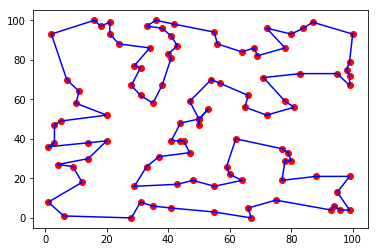

In [15]:
# Crear lista con arcos seleccionados en la solucion
L = [(i,j) for i,j in A if vx[i,j]>0]

# Recuperar el tour como un ordenamiento de los nodos que empieza y termina en el deposito
T = [0]
# nodo actual:
i = 0
while L!=[]:
    # Determinar un sucesor de i
    N = [j for j in V if (i,j) in L] 
    j = N.pop()
    a = (i,j) 
    L.remove(a)
    # Colocar sucesor en la lista del tour y actualizar i
    T.append(j)
    i = j
        
# Graficar el tour
dibujarTour(coordx, coordy, T)    

## Código completo

Se reproduce a continuación el código completo del modelo anterior.

Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter TimeLimit to 180.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 10102 rows, 10200 columns and 49900 nonzeros
Variable types: 0 continuous, 10200 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+02]
Presolve time: 0.07s
Presolved: 10102 rows, 10200 columns, 49900 nonzeros
Variable types: 0 continuous, 10200 integer (10100 binary)

Root relaxation: objective 6.460504e+02, 359 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  646.05037    0  164          -  646.05037      -     -    0s
H    0     0                    4628.3227335  646.05037  86.0%     -    0s
H    0   

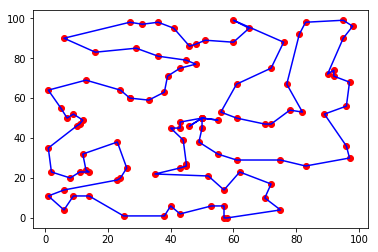

In [18]:
# Implementación de modelos lineales enteros
# Problema del agente viajero asimétrico múltiple (k-ATSP)
# Formulación compacta

# Luis M. Torres (EPN 2019)

from gurobipy import *
import random as rm
import matplotlib.pyplot as plt

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

# Numero de nodos del grafo
n = 100

# Numero de toures en la solucion
k = 3

# Nodos del grafo
V = tuplelist(range(0,n+1))
# Nodos sin el depósito
V1 = [i for i in V if i!=0]

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
# El depósito está en el centro
coordx={0 : 50}
coordy={0 : 50}
for i in V1:
    coordx[i] = rm.randint(0,100)
    coordy[i] = rm.randint(0,100)

# los costos son las distancias eculideanas
c = tupledict({})
for i in V:
    for j in V:
        # evitar lazos
        if i != j:
            c[i,j]= math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
 
A = c.keys()

# Arcos no incidentes al deposito
A1 = tuplelist([(i,j) for (i,j) in A if i!=0 and j!=0])

try:
    # Crear el objeto modelo
    m = Model('k-tsp-compacto')

    # Variables de seleccion de arcos
    x = m.addVars(A, name="x", vtype=GRB.BINARY)

    # Variables de ordenamiento de nodos
    u = m.addVars(V1, name="u", vtype=GRB.INTEGER, ub=n, lb=1)

    # Crear la funcion objetivo
    m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

    # Restricciones de grado saliente
    m.addConstrs((x.sum(i,'*') == 1 for i in V1), "g_saliente")

    # Restricciones de grado entrante
    m.addConstrs((x.sum('*', i) == 1 for i in V1), "g_entrante")

    # Restriccion de grado saliente deposito
    m.addConstr(x.sum(0,'*') == k, "d_saliente")

    # Restriccion de grado entrante deposito
    m.addConstr(x.sum('*', 0) == k, "d_entrante")

    # Restricciones de ordenamiento de nodos
    m.addConstrs((u[j] >= u[i] + 1 - n*(1- x[i,j]) for i,j in A1), "ordenamiento")

    # Escribir el modelo a un archivo
    # m.write('k-tsp-compacto.lp')

    # Terminar al alcanzar un Gap del 10%
    m.Params.MIPGap = 0.1

    # Terminar luego de 60 segundos
    m.Params.TimeLimit = 180

    # Calcular la solucion optima
    m.optimize()

    # Escribir la solucion
    if (m.status == GRB.Status.OPTIMAL or 
       m.status == GRB.Status.SUBOPTIMAL):
        # Recuperar los valores de las variables
        vx = m.getAttr('x', x)
        print('\nToures optimos:')
        for i,j in A:
            if vx[i,j] > 0:
                print('{} -> {}'.format(i, j))
                
    # Crear lista con arcos seleccionados en la solucion
    L = [(i,j) for i,j in A if vx[i,j]>0]

    # Recuperar el tour como un ordenamiento de los nodos que empieza y termina en el deposito
    T = [0]
    # nodo actual:
    i = 0
    while L!=[]:
        # Determinar un sucesor de i
        N = [j for j in V if (i,j) in L] 
        j = N.pop()
        a = (i,j) 
        L.remove(a)
        # Colocar sucesor en la lista del tour y actualizar i
        T.append(j)
        i = j
        
    # Graficar el tour
    dibujarTour(coordx, coordy, T)    

except GurobiError as e:
    print('Se produjo un error de Gurobi: codigo: ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Se produjo un error de atributo')

### Creando el conjunto potencia de un conjunto en Python

Para construir el conjunto potencia (la familia de subconjuntos) de cualquier iterable, pueden usarse las funciones `chain` y `combinations` del módulo `itertools`.

In [9]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

V = tuplelist([1, 2, 3, 4, 5])
L = list(powerset(V))
print V
print L

for W in L:
    if W!=() and W!=tuple(V):
        print W, len(W)

[1, 2, 3, 4, 5]
[(), (1,), (2,), (3,), (4,), (5,), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 4), (1, 3, 5), (1, 4, 5), (2, 3, 4), (2, 3, 5), (2, 4, 5), (3, 4, 5), (1, 2, 3, 4), (1, 2, 3, 5), (1, 2, 4, 5), (1, 3, 4, 5), (2, 3, 4, 5), (1, 2, 3, 4, 5)]
(1,) 1
(2,) 1
(3,) 1
(4,) 1
(5,) 1
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 4) 2
(3, 5) 2
(4, 5) 2
(1, 2, 3) 3
(1, 2, 4) 3
(1, 2, 5) 3
(1, 3, 4) 3
(1, 3, 5) 3
(1, 4, 5) 3
(2, 3, 4) 3
(2, 3, 5) 3
(2, 4, 5) 3
(3, 4, 5) 3
(1, 2, 3, 4) 4
(1, 2, 3, 5) 4
(1, 2, 4, 5) 4
(1, 3, 4, 5) 4
(2, 3, 4, 5) 4
